# TEORIJA UZORAKA I PLANIRANJE EKSPERIMENATA

U ovom radu korišćeni su podaci iz ankete Living Standards Measurement Study (LSMS), koju je u ime Svetske banke sproveo Republički zavod za statistiku u maju i junu 2007. godine na teritoriji Republike Srbije. Ova anketa pruža detaljne informacije o životnim uslovima, ekonomskim aktivnostima i demografskim karakteristikama stanovnika Srbije, a njen cilj je da pomogne u boljem razumevanju faktora koji utiču na socijalni i ekonomski status građana. Podaci iz LSMS-a omogućavaju analizu različitih aspekata života, a u ovom radu fokusiraću se na analizu mesečnih zarada, kako bih utvrdio koji faktori utiču na njihove varijacije u Srbiji i u kojoj meri svaki od njih doprinosi tim razlikama. Prosečna mesečna zarada korišćena je kao pokazatelj ekonomske situacije, pružajući uvid u životne uslove prosečnog stanovnika zemlje. Takođe, ukupne godišnje zarade predstavljaju značajan pokazatelj ekonomske situacije, jer direktno utiču na bruto domaći proizvod zemlje.


Anketna pitanja za odabrane varijable:
    
    -plata: Neto prihod prethodnog meseca od glavnog posla
    
    -obrazovanje: U upitniku je ispitanicima data ISCED skala, varijabla prekodirana tako da predstavlja godine obrazovanja
    
    -obr3: Tri obrazovne kategorije (osnovna, srednja, visoka škola)
    
    -starost: Godine ispitanika u trenutku anketiranja
    
    -satiRada: Koliko sati je ispitanik radio na glavnom poslu u toku prethodne nedelje
    
    -zene: dve kategorije (Zena, Muskarac)
    
    -urban: dve kategorije (Grad, Selo)
    
    -region: četiri kategorije (Beograd, Vojvodina, Zapadna Srbija i Šumadija, Južna i jugoistočna Srbija)




## UVOZ BIBLIOTEKA I FORMATIRANJE IZLAZA

Počinjem sa uvozom neophodnih biblioteka i podešavanjem prikaza numeričkih vrednosti — brojevi su zaokruženi na dve decimale, a hiljade su razdvojene tačkom radi lakšeg čitanja.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import locale
locale.setlocale(locale.LC_ALL, 'sr_RS.UTF-8')
def form(value):
    if isinstance(value, (int, float, np.number)):
        return locale.format_string('%.2f', value, grouping=True)
    return str(value)
pd.options.display.float_format = lambda x: form(x)
np.set_printoptions(formatter={'all': lambda x: form(x)})

## UCITAVANJE PODATAKA I PREGLED PODATAKA

Podatke sam preuzeo kao STATA fajl (.dta), pri čemu su osnovne manipulacije, poput izbacivanja nezaposlenih i izdvajanja relevantnih varijabli,  prethodno izvršene direktno u Stata - i.

Na taj način, u Python učitavam već pripremljenu bazu, fokusiranu isključivo na zaposlene osobe.
Pozivanjem df.head(10) dobijamo pregled prvih deset ispitanika:


In [8]:
df = pd.read_stata('TU.dta')
df.head(10)

,zene,starost,satiRada,plata,region,urban,obr3,obrazovanje
0,Zena,47,"42,00",28000,Sumadija i Zapadna Srbija,Grad,Srednja skola,"12,00"
1,Muskarac,58,"42,00",9000,Sumadija i Zapadna Srbija,Grad,Osnovno skola ili manje,"8,00"
2,Muskarac,24,"42,00",11000,Sumadija i Zapadna Srbija,Grad,Osnovno skola ili manje,"8,00"
3,Zena,40,"48,00",23000,Sumadija i Zapadna Srbija,Grad,Srednja skola,"12,00"
4,Muskarac,46,"48,00",31000,Sumadija i Zapadna Srbija,Grad,Visoko obrazovanje,"16,00"
5,Muskarac,49,"42,00",11000,Sumadija i Zapadna Srbija,Grad,Visoko obrazovanje,"16,00"
6,Zena,40,"42,00",11000,Sumadija i Zapadna Srbija,Grad,Srednja skola,"12,00"
7,Muskarac,46,"42,00",14500,Sumadija i Zapadna Srbija,Grad,Srednja skola,"12,00"
8,Zena,43,"42,00",19800,Sumadija i Zapadna Srbija,Grad,Visoko obrazovanje,"14,00"
9,Zena,32,"4,00",12200,Sumadija i Zapadna Srbija,Grad,Srednja skola,"12,00"


Na prvi pogled izgleda da su varijable satiRada i obrazovanje celi brojevi, ali su učitani u float formatu.

Da bi dobili detaljniji uvid u bazu zovemo sledecu funkciju

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5141 entries, 0 to 5140
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   zene         5141 non-null   category
 1   starost      5141 non-null   int8    
 2   satiRada     5135 non-null   float64 
 3   plata        5141 non-null   int32   
 4   region       5141 non-null   category
 5   urban        5141 non-null   category
 6   obr3         5141 non-null   category
 7   obrazovanje  5141 non-null   float32 
dtypes: category(4), float32(1), float64(1), int32(1), int8(1)
memory usage: 106.1 KB


## ČIŠĆENJE PODATAKA

Uočavam da varijabla satiRada (zajedno sa satnicom) ima 6 ispitanika koji nisu odgovorili, njih uklanjam iz baze.

In [13]:
df = df[df['satiRada'].isna() == 0]

In [14]:
for var in ['satiRada', 'obrazovanje']:
    razlike = df[var].unique() - df[var].unique().astype(int)
    if razlike.all() == 0:
        print(f'Varijabla {var} sadrži samo cele brojeve, treba je prekodirati u int')
    else:
        print(f'Varijabla {var} sadrži decimale, treba ostati float')

Varijabla satiRada sadrži samo cele brojeve, treba je prekodirati u int
Varijabla obrazovanje sadrži samo cele brojeve, treba je prekodirati u int


Potvrđujem da su vrednosti varijabla obrazovanje i satiRada celi brojevi skladišteni kao brojevi sa pokretnim zarezom, te ih pretvaram u cele brojeve. 

In [16]:
df['obrazovanje'] = df['obrazovanje'].astype(int)
df['satiRada'] = df['satiRada'].astype(int)

Ova promena ima estetski efekat, jer rezultuje lakšim pregledom podataka, ali i poboljšava memorijsku efikasnost, jer celobrojni podaci zauzimaju manje memorije nego brojevi sa pokretnim zarezom. Iako na bazi ovih dimenzija promena neće doneti veliku uštedu u memoriji, ovakve optimizacije postaju važnije kada se radi sa većim bazama podataka.

In [18]:
df.describe()

,starost,satiRada,plata,obrazovanje
count,"5.135,00","5.135,00","5.135,00","5.135,00"
mean,"42,04","43,53","20.435,09","11,31"
std,"11,84","17,41","14.760,90","2,98"
min,"16,00","0,00","500,00","0,00"
25%,"33,00","40,00","12.000,00","11,00"
50%,"42,00","40,00","18.000,00","12,00"
75%,"51,00","50,00","25.000,00","12,00"
max,"84,00","126,00","230.000,00","20,00"


Uočavam problem u minimalnoj  vrednosti varijable koja označava nedeljne sate rada i u maksimalnoj vrednosti varijable koja označava starost ispitanika. 

Kako je predmet ispitivanja isključivo radna populacija, iz  baze izbacujem one koji su prijavili 0 radna sata nedeljno i one koji su prešli starosnu granicu za penziju. U Srbiji 2007 godine starosna granica za muškarce bila je 65, a za žene 60 godina.

In [20]:
df = df[(df['satiRada'] > 0) & (((df['starost'] < 65) & (df['zene'] == 'Muskarac')) | ((df['starost']< 60) & (df['zene'] == 'Zena')))]
df.describe()

,starost,satiRada,plata,obrazovanje
count,"4.776,00","4.776,00","4.776,00","4.776,00"
mean,"40,94","45,08","20.903,81","11,51"
std,"10,70","15,39","14.459,53","2,73"
min,"16,00","1,00","500,00","0,00"
25%,"32,00","40,00","12.000,00","11,00"
50%,"41,00","40,00","18.000,00","12,00"
75%,"50,00","50,00","25.000,00","12,00"
max,"64,00","126,00","200.000,00","20,00"


Kako je baza sada kvalitativno očišćena, pre kvantitativnog čišćenja (izbacivanja outliera) korisno je vizualizovati podatke.

### VIZUALIZACIJA RASPODELA

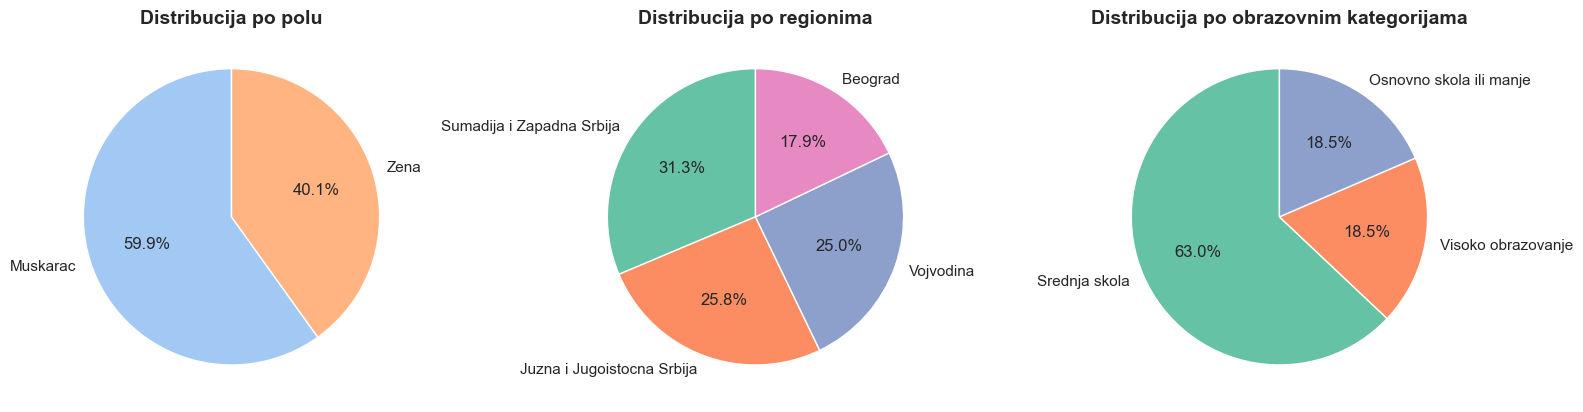

In [23]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(16, 16))

plt.subplot(1, 3, 1)
pol_counts = df['zene'].value_counts()
plt.pie(pol_counts, labels=pol_counts.index, autopct='%1.1f%%', startangle=90, 
        colors=sns.color_palette("pastel", len(pol_counts)), labeldistance=1.1)
plt.title('Distribucija po polu', fontsize=14, fontweight='bold')

plt.subplot(1, 3, 2)
region_counts = df['region'].value_counts()
plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=90, 
        colors=sns.color_palette("Set2", len(region_counts)), labeldistance=1.1)
plt.title('Distribucija po regionima', fontsize=14, fontweight='bold')

plt.subplot(1, 3, 3)
obr3_counts = df['obr3'].value_counts()
plt.pie(obr3_counts, labels=obr3_counts.index, autopct='%1.1f%%', startangle=90, 
        colors=sns.color_palette("Set2", len(obr3_counts)), labeldistance=1.1)
plt.title('Distribucija po obrazovnim kategorijama', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

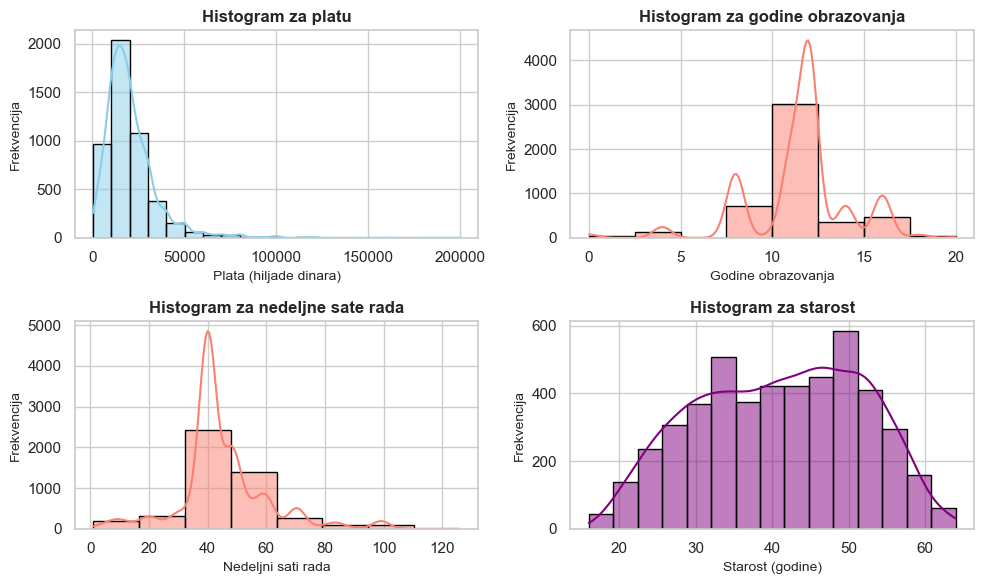

In [24]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2, 2, 1)
sns.histplot(df['plata'], bins=20, kde=True, color='skyblue', edgecolor='black', stat="count")
plt.title('Histogram za platu', fontsize=12, fontweight='bold')
plt.xlabel('Plata (hiljade dinara)', fontsize=10)
plt.ylabel('Frekvencija', fontsize=10)
plt.grid(True)  

plt.subplot(2, 2, 2)
sns.histplot(df['obrazovanje'], bins=8, kde=True, color='salmon', edgecolor='black', stat="count")
plt.title('Histogram za godine obrazovanja', fontsize=12, fontweight='bold')
plt.xlabel('Godine obrazovanja', fontsize=10)
plt.ylabel('Frekvencija', fontsize=10)
plt.grid(True)  

plt.subplot(2, 2, 3)
sns.histplot(df['satiRada'], bins=8, kde=True, color='salmon', edgecolor='black', stat="count")
plt.title('Histogram za nedeljne sate rada', fontsize=12, fontweight='bold')
plt.xlabel('Nedeljni sati rada', fontsize=10)
plt.ylabel('Frekvencija', fontsize=10)
plt.grid(True)

plt.subplot(2, 2, 4) 
sns.histplot(df['starost'], bins=15, kde=True, color='purple', edgecolor='black', stat="count")
plt.title('Histogram za starost', fontsize=12, fontweight='bold')
plt.xlabel('Starost (godine)', fontsize=10)
plt.ylabel('Frekvencija', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()


Kako je varijabla plata ciljana varijabla ovog rada, bilo bi poželjno da njena raspodela ne odstupa značajno od normalne.

Zato primenjujem Jarque-Bera test, koji testira sledeće hipoteze:

    - H₀: Raspodela varijable plata se ne razlikuje značajno od normalne

    - H₁: Raspodela varijable plata se statistički značajno razlikuje od normalne

Statistika se poredi sa vrednošću hi-kvadrat sa 2 stepena slobode. Za nivo značajnosti od 5%, kritična vrednost je 5.99

Posto ću ovaj test koristiti više puta, definisao sam funkciju jb() koja vraća seriju podataka sa ostvarenom JB statistikom i verovatnocom greske prve vrste, takođe printuje da li je nulta hipoteza odbačena ili nije na osnovu zadatog rizika greške alfa

In [26]:
def jb( var, alfa = 0.1):
    mi3, mi4 = [((var - var.mean())**momenat).mean() for momenat in [3,4]]
    sigma3, sigma4 = [var.std() ** momenat for momenat in [3,4]]
    S, K = mi3 / sigma3, mi4 / sigma4
    JB = len(var) * (np.square(S) + np.square(K - 3) / 4) / 6
    p = stats.chi2.sf(JB, df=2)
    if p < alfa:
        print(f'Uz rizik greške od {alfa * 100}%, odbacujem nultu hipotezu i zaključujem da se raspodela varijable {var.name} statistički značajno razlikuje od normalne')
    else:
        print(f'Uz rizik greške od {alfa * 100}%, ne odbacujem nultu hipotezu i zaključujem da se raspodela varijable {var.name} ne razlikuje značajno od normalne')
    return pd.Series([JB, p], index= ['JB', 'p'])

In [27]:
jb(df['plata'])

Uz rizik greške od 10.0%, odbacujem nultu hipotezu i zaključujem da se raspodela varijable plata statistički značajno razlikuje od normalne


JB   56.123,72
p         0,00
dtype: float64

In [28]:
df['plata'].name

'plata'

S obzirom na to da je Jarque-Bera test pokazao značajno odstupanje od normalne raspodele plata, dodatno ću da očistim podatke pa ću da ponovim test.

Nakon što su prethodno uklonjene kvalitativno netipične vrednosti (ispitanici koji nisu radili, penzioneri), u nastavku pristupam uklanjanju kvantitativnih outliera.

Možda izgleda intuitivno eliminisati netipične vrednosti za platu pomoću interkvartilne razlike, ali potrebno je malo dublje sagledati problem.

Kako postoje podaci o broju nedeljnih radnih sati, varijabla plate se mora kontrolisati varijablom satiRada.

Na primer, ako ispitanik radi duplo više od proseka baze i ima duplo veću platu od prosečne, on ne predstavlja outlier jer ima prosečnu zaradu po radnom satu. S druge strane, ako ispitanik radi polovinu radnih sati od proseka baze i ima duplo veću platu od prosečne, on predstavlja outlier jer ima u proseku četiri puta veću zaradu po satu od nekoga ko radi prosečan broj sati.

Da bih preciznije identifikovao netipične vrednosti, formiram varijablu satnica kao odnos mesečne zarade i prosečnih mesečnih radnih sati. Kako je varijabla plata na mesečnom nivou, a satiRada na nedeljnom, sate množim sa 52 da bih dobio godišnji broj radnih sati, a potom delim sa 12 da bih dobio prosečan mesečni broj radnih sati.


In [31]:
df['satnica'] = df['plata'] / (df['satiRada'] * (52 / 12))

In [32]:
df['satnica'].describe()

count   4.776,00
mean      127,13
std       224,14
min         2,75
25%        62,50
50%        95,19
75%       144,23
max     7.692,31
Name: satnica, dtype: float64

Najmanja vrednost za satnicu 2.75 dinara. Kako je u maju 2007. godine minimalna propisana zarada po satu bila 55 dinara, izbacujem sve ispitanike kojima je preračunata satnica manja od minimalca. 

In [34]:
print((df['satnica'] < 55).sum())
df = df[df['satnica'] > 55]

889


Na osnovu interkvartilne razlike izbacujem netipične vrednosti za nedeljne sate rada i preračunate satnice, eliminišući samo one ekstremne vrednosti koje ne prate uobičajene obrasce, dok se podaci koji odražavaju stvarne razlike u radnim satima i zaradama zadržavaju.

In [36]:
for var in ['satiRada', 'satnica']:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    
    donjaGranica = Q1 - 1.5 * IQR
    gornjaGranica = Q3 + 1.5 * IQR

    ukupnoIzbaceno = len(df[(df[var] < donjaGranica) | (df[var] > gornjaGranica)])
    df = df[(df[var] >= donjaGranica) & (df[var] <= gornjaGranica)].reset_index(drop = True)
    print(f'Iz baze je izbacen svaki ispitanik kod koga je {var} manja od {donjaGranica}, odnosno veca od {gornjaGranica}.')
    print(f'Iz baze je izbaceno  {ukupnoIzbaceno} outliera')
    print(f'Nakon izbacivanja outliera: {len(df)}')

Iz baze je izbacen svaki ispitanik kod koga je satiRada manja od 28.0, odnosno veca od 60.0.
Iz baze je izbaceno  518 outliera
Nakon izbacivanja outliera: 3369
Iz baze je izbacen svaki ispitanik kod koga je satnica manja od -28.846153846153825, odnosno veca od 263.46153846153845.
Iz baze je izbaceno  174 outliera
Nakon izbacivanja outliera: 3195


In [37]:
df.describe()

,starost,satiRada,plata,obrazovanje,satnica
count,"3.195,00","3.195,00","3.195,00","3.195,00","3.195,00"
mean,"40,58","43,42","21.569,35","11,81","116,07"
std,"10,35","6,68","8.720,20","2,39","46,95"
min,"16,00","28,00","8.000,00","0,00","55,29"
25%,"32,00","40,00","15.000,00","11,00","76,92"
50%,"41,00","40,00","20.000,00","12,00","103,85"
75%,"49,00","48,00","26.000,00","12,00","144,23"
max,"64,00","60,00","64.000,00","20,00","261,54"


Nakon generalnog čišćenja varijable plata baza izgleda ovako

Početni broj ispitanika bio je 5141, a nakon čišćenja ostalo je 3195, što znači da je 38% podataka  sadržavalo netipične vrednosti, bilo kvalitativne ili kvantitativne.

### VIZUALIZACIJA RASPODELA

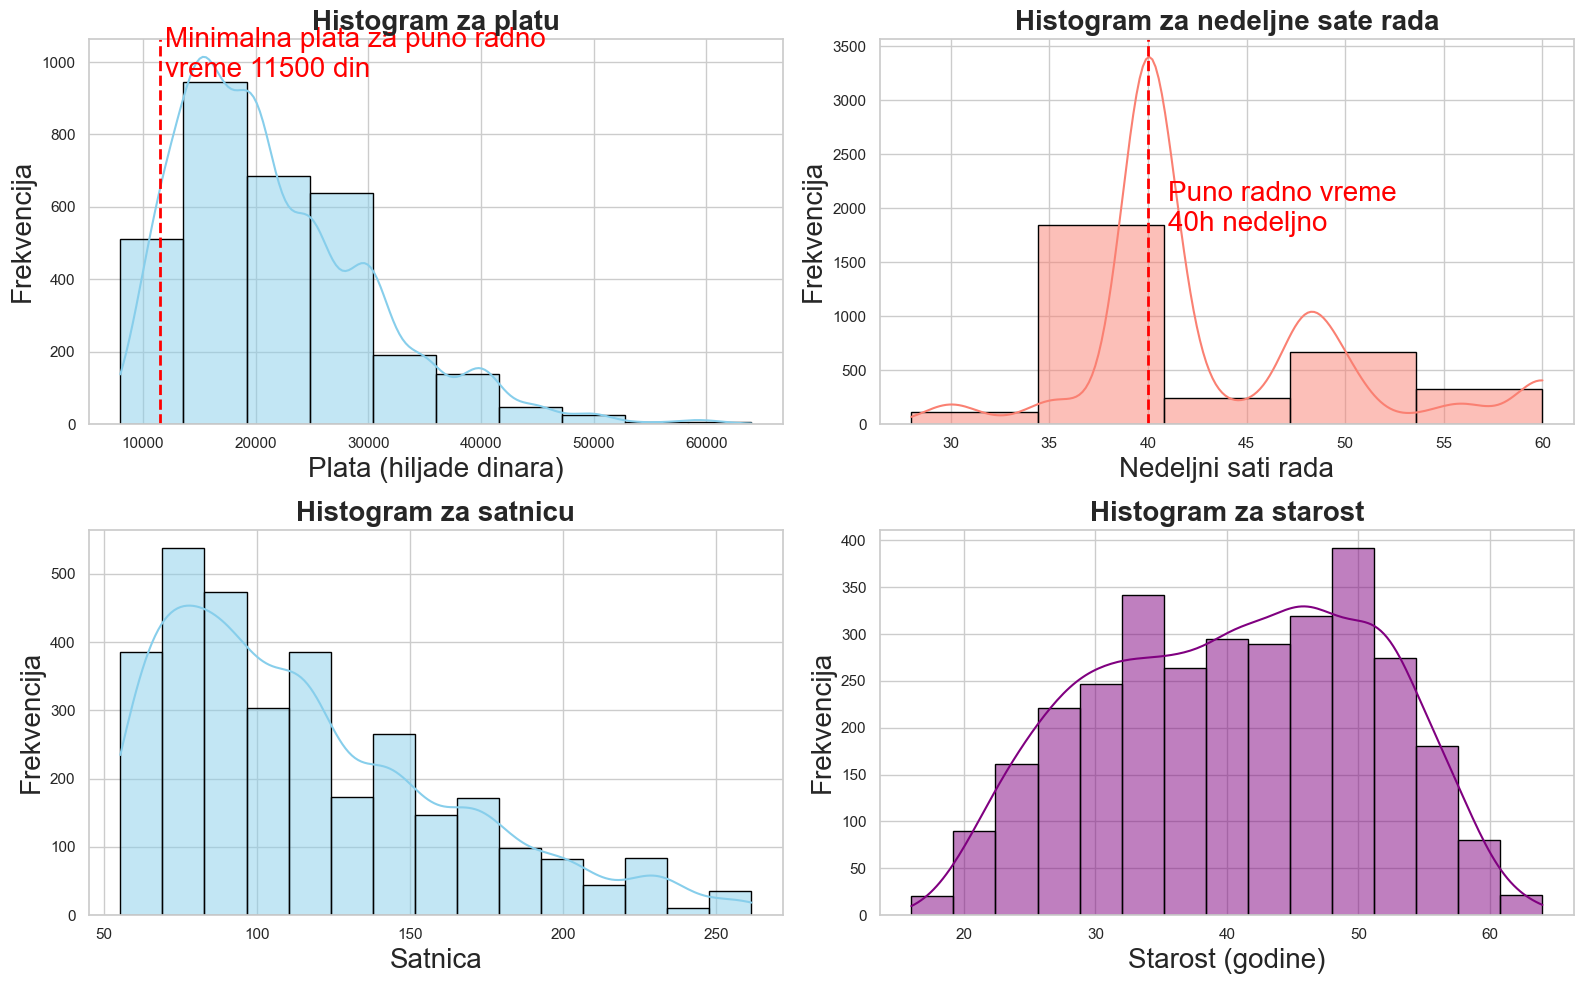

In [40]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['plata'], bins=10, kde=True, color='skyblue', edgecolor='black', stat="count")

plt.title('Histogram za platu', fontsize=20, fontweight='bold')
plt.xlabel('Plata (hiljade dinara)', fontsize=20)
plt.ylabel('Frekvencija', fontsize=20)

plt.axvline(x=11500, color='red', linestyle='--', linewidth=2 )
plt.text(12000, plt.ylim()[1] * 0.9, 'Minimalna plata za puno radno\nvreme 11500 din', color='red', fontsize=20)
plt.grid(True)

plt.subplot(2, 2, 2)
sns.histplot(df['satiRada'], bins=5, kde=True, color='salmon', edgecolor='black', stat="count")
plt.title('Histogram za nedeljne sate rada', fontsize=20, fontweight='bold')
plt.xlabel('Nedeljni sati rada', fontsize=20)
plt.ylabel('Frekvencija', fontsize=20)
plt.axvline(x=40, color='red', linestyle='--', linewidth=2)
plt.text(41, plt.ylim()[1] * 0.5, 'Puno radno vreme\n40h nedeljno', color='red', fontsize=20)
plt.grid(True)

plt.subplot(2, 2, 3)
sns.histplot(df['satnica'], bins=15, kde=True, color='skyblue', edgecolor='black', stat="count")
plt.title('Histogram za satnicu', fontsize=20, fontweight='bold')
plt.xlabel('Satnica', fontsize=20)
plt.ylabel('Frekvencija', fontsize=20)
plt.grid(True)

plt.subplot(2, 2, 4) 
sns.histplot(df['starost'], bins=15, kde=True, color='purple', edgecolor='black', stat="count")
plt.title('Histogram za starost', fontsize=20, fontweight='bold')
plt.xlabel('Starost (godine)', fontsize=20)
plt.ylabel('Frekvencija', fontsize=20)
plt.grid(True)

plt.tight_layout()
plt.show()

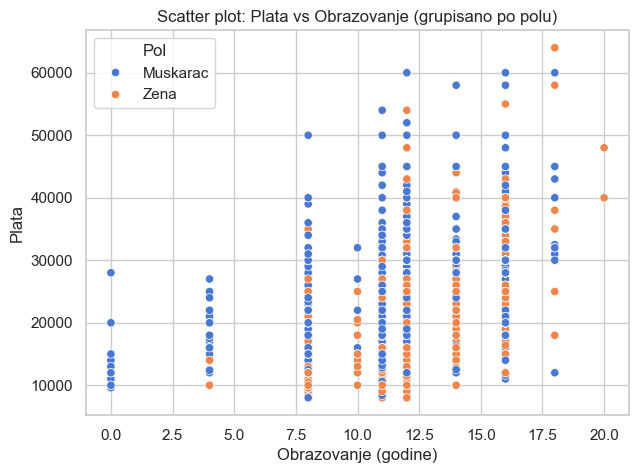

In [41]:
plt.figure(figsize=(7, 5))  

sns.scatterplot(x=df['obrazovanje'], y=df['plata'], hue=df['zene'])

plt.title('Scatter plot: Plata vs Obrazovanje (grupisano po polu)')
plt.xlabel('Obrazovanje (godine)')
plt.ylabel('Plata')

plt.legend(title='Pol')

plt.show()

Na dijgramu raspršenosti može se primetiti da muškarci sa srednjom školom ili manje (do 12g obrazovanja) zarađuju više od žena.

In [43]:
df.iloc[df['plata'].sort_values(ascending=False).index[:10]]

,zene,starost,satiRada,plata,region,urban,obr3,obrazovanje,satnica
2813,Zena,40,60,64000,Vojvodina,Grad,Visoko obrazovanje,18,"246,15"
379,Zena,28,60,60000,Beograd,Grad,Srednja skola,12,"230,77"
643,Muskarac,40,60,60000,Beograd,Grad,Visoko obrazovanje,18,"230,77"
399,Muskarac,29,60,60000,Beograd,Grad,Visoko obrazovanje,16,"230,77"
410,Muskarac,53,60,60000,Beograd,Grad,Visoko obrazovanje,18,"230,77"
770,Muskarac,51,60,60000,Sumadija i Zapadna Srbija,Grad,Visoko obrazovanje,16,"230,77"
568,Muskarac,35,60,60000,Beograd,Selo,Srednja skola,12,"230,77"
2886,Muskarac,42,60,58000,Vojvodina,Grad,Visoko obrazovanje,14,"223,08"
3115,Muskarac,43,55,58000,Vojvodina,Grad,Visoko obrazovanje,16,"243,36"
42,Zena,41,52,58000,Sumadija i Zapadna Srbija,Selo,Visoko obrazovanje,18,"257,40"


Pregled 10 ispitanika sa najvećom zabeleženom zaradom u bazi otkriva jasan obrazac:

    Svi rade prekovremeno, pri čemu mnogi dostižu gornju granicu radnog vremena koju sam prethodno definisao kao tipičnu (do 60 sati nedeljno), na osnovu interkvartilne razlike.
    Većina su muškarci,
    U regionima preovladava Beograd
    Uglavnom žive u urbanim sredinama 
    Visoko su obrazovani


In [45]:
jb(df['plata'])

Uz rizik greške od 10.0%, odbacujem nultu hipotezu i zaključujem da se raspodela varijable plata statistički značajno razlikuje od normalne


JB   929,93
p      0,00
dtype: float64

Ponovljen test normalnosti daje statistiku JB = 929, što je i dalje veće od kritične vrednosti 5.99, ali se smanjila u odnosu na prethodnu vrednost (56177), što ukazuje na to da je postignut značajan napredak u eliminaciji netipičnih vrednosti.

Kako ću u ovom radu ocenjivati sredinu plate, dovoljno je da distribucija sredine plate iz slučajnih uzoraka ima normalnu raspodelu. Prema centralnoj graničnoj teoremi (CGT), u teoriji, ova pretpostavka bi trebala da važi za uzorake veće od 30, jer veliki uzorci obezbeđuju približavanje normalnoj distribuciji bez obzira na oblik osnovne distribucije.

Međutim, kako bih dodatno osigurao validnost ove pretpostavke, odlučio sam da sprovedem dodatnu proveru normalnosti distribucije sredina plata koristeći bootstrap metodologiju.

Napravio sam klasu Bootstrap() koja izvlači k (obično od 1000 do 10000) uzoraka sa vraćanjem iz baze veličine n (postavio sam kao podrazumevanu vrednost 10% veličine baze, odnosno 319), za svaki uzorak se računa sredina i varijansa. Klasi se pri inicijalizaciji prosledjuje lista rizika greške prve vrste i onda sve metode dinamički koriste te alfe, podrazumevane vrednosti su 1%, 5% i 10%.

Kratak opis metoda:

    fit(k):    Generiše k uzoraka i računa sredine i varijanse
    sredina / varijansa:    Prosečne vrednosti sredina / varijansi iz uzoraka
    interval():    Računa intervale poverenja za sve nivoe poverenja
    d():    hiperparametar za računanje optimalne veličine uzorka, predstavlja najveće dozvoljeno odstupanje pri uzoračkom ocenjivanju za svaki nivo značajnosti 
    plotDist():    Vizualizuje distribuciju sredina sa prikazom intervala poverenja
    obimUzorka():    Računa optimalni obim uzorka za svaki nivo značajnosti
    summary:    Prikaz svih ključnih statistika i JB testa

In [48]:
class Bootstrap():
    def __init__(self, df, alfa = None, n=None):
        self.df = df
        default = [0.1, 0.05, 0.01]
        if alfa is None:
            self.alfa = default
        elif isinstance(alfa, (float, int)):
            if alfa < 0 or alfa > 1:
                raise ValueError('Alfa mora biti izmedju 1 i 0')
            self.alfa = sorted(set(default + [alfa]))
        else:
            for a in alfa:
                if a < 0 or a > 1:
                    raise ValueError('Alfa mora biti izmedju 1 i 0')
            self.alfa = sorted(set(default + list(alfa)))
        self.n = n if n is not None else int(len(df) * 0.1)

        self.N = len(df)

    def fit(self, k, seed=42):
        self.sredineUzoraka = []
        self.standardneDevijacije = []
        for i in range(k):
            uzorak = self.df['plata'].sample(n=self.n, random_state=seed + i)
            self.sredineUzoraka.append(uzorak.mean())
            self.standardneDevijacije.append(uzorak.std())
        self.sredineUzoraka = pd.Series(self.sredineUzoraka, name = 'prosek')
        self.standardneDevijacije = pd.Series(self.standardneDevijacije, name = 'standardna devijacija')

    @property
    def sredina(self):
        return self.sredineUzoraka.mean()

    @property
    def std(self):
        return self.standardneDevijacije.mean()

    def interval(self, alfa = None, x = None):
        x = self.sredineUzoraka if x is None else x
        alfa = self.alfa if alfa is None else alfa
        alfa = np.atleast_1d(alfa)
        intervali = []
        for a in alfa:
            
            donja = x.quantile(a / 2)
            gornja = x.quantile(1 - a / 2)
            intervali.append([donja, gornja])
        return pd.DataFrame(intervali, columns=["donja", "gornja"], index = [f"{int((1 - a) * 100)}%" for a in alfa])

    def d(self, alfa = None):
        alfa = self.alfa if alfa is None else alfa
        intervals = self.interval(alfa)
        return ((intervals["gornja"] - intervals["donja"]) / 2).rename('d')

    def plotDist(self, alfa = None, x = None, target = None):
        x = self.sredineUzoraka if x is None else x
        alfa = self.alfa if alfa is None else alfa
        boje = plt.cm.tab10.colors
        plt.figure(figsize=(12, 6))
        sns.histplot(x, bins=50, kde=True, color='skyblue', edgecolor='black', stat="count")
        plt.title(f'Distribucija bootstrap {x.name} plata', fontsize=16)
        plt.xlabel(f'{x.name} plata', fontsize=14)
        plt.ylabel('Frekvencija', fontsize=14)
        plt.grid(True)

        plt.axvline(x=x.mean(), color='blue', linestyle='-', label=f'Srednja vrednost: {x.mean():.2f}')
        for a, boja in zip(alfa, boje):
            donja, gornja =  self.interval(a, x = x).iloc[0]
            plt.axvline(x=donja, color= boja, linestyle='--', label=f'{int((1 - a)*100)}% interval')
            plt.axvline(x=gornja, color= boja, linestyle='--')
            
        if target is not None:
            plt.axvline(target.mean(), color='red', linestyle='-', linewidth=2, label=f'Target: {target.mean():.2f}')

        plt.legend()
        plt.show()

    def obimUzorka(self, alfa = None):
        alfa = self.alfa if alfa is None else alfa
        alfa = np.atleast_1d(alfa)
        nList, dList, indeksi = [], [], []
    
        for a in alfa:
            d = self.d([a]).values[0]
            Z = stats.norm.ppf(1 - a / 2)
            Sy2 = np.square(self.standardneDevijacije).mean()
            n0 = (np.square(Z) * Sy2) / np.square(d)
            n = int(1 / (1 / n0 + 1 / self.N))
            nList.append(n)
            indeksi.append(f"{int((1 - a) * 100)}%")
            dList.append(d)
    
        return pd.DataFrame({'n': nList, 'd': dList}, index=indeksi)

    @property
    def summary(self):
        data = pd.Series({"Prosečna sredina": self.sredina, "Prosečna standardna devijacija": self.std})
        
        d = self.d()
        d.index = [f"d({(1 - a) * 100:.0f})%" for a in self.alfa]
    
        data = pd.concat([data,jb(self.sredineUzoraka)])
    
        return pd.DataFrame(data)
        
    def __repr__(self):
        return f"Bootstrap | n={self.n} | N={self.N} | bootstrap uzoraka={len(self.sredineUzoraka)}"

In [49]:
alfa10 = np.linspace(0.1,0.5,10)

In [50]:
bs = Bootstrap(df, alfa = alfa10)
bs.fit(5000)
bs.summary

Uz rizik greške od 10.0%, ne odbacujem nultu hipotezu i zaključujem da se raspodela varijable prosek ne razlikuje značajno od normalne


,0
Prosečna sredina,"21.554,25"
Prosečna standardna devijacija,"8.697,91"
JB,"2,61"
p,"0,27"


### Rezultat JB testa se tumači na sledeći način:

    Ako bih izvukao 5000 uzoraka iz baze veličine 319 (10% populacije) raspodela njihovih aritmetičkih sredina ne bi stratistički značajno odstupala od N ~ (21555, 8697^2)

Ispod su predstavljene proseci i standardne devijacije uzoraka sa intervalima poverenja

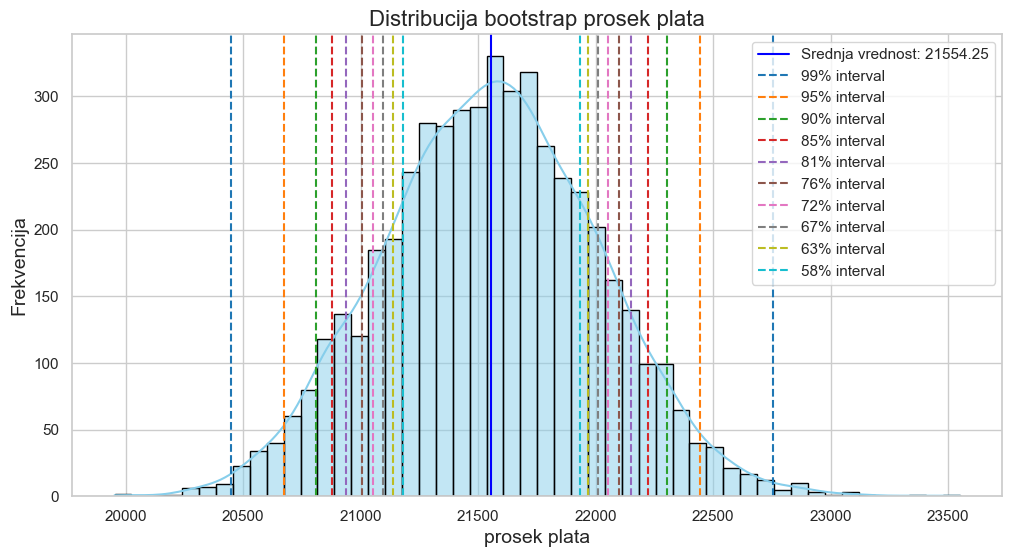

Bootstrap | n=319 | N=3195 | bootstrap uzoraka=5000


In [52]:
bs.plotDist()
print(bs)

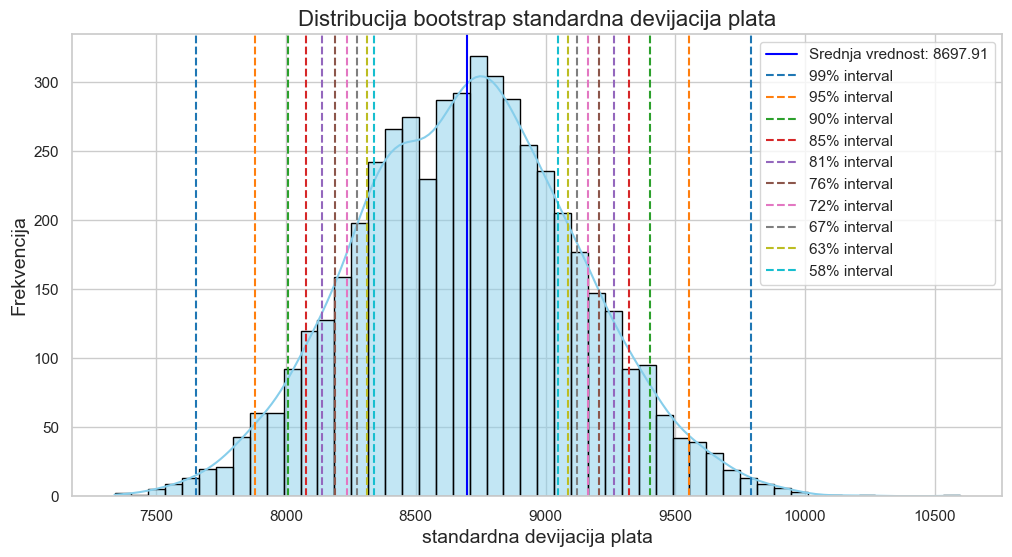

Bootstrap | n=319 | N=3195 | bootstrap uzoraka=5000


In [53]:
bs.plotDist(x =bs.standardneDevijacije)
print(bs)

In [54]:
obim = bs.obimUzorka()
obim

,n,d
99%,338,"1.153,06"
95%,332,"885,39"
90%,330,"745,95"
85%,321,"672,73"
81%,320,"606,26"
76%,323,"547,48"
72%,323,"498,52"
67%,320,"456,96"
63%,322,"415,33"
58%,325,"375,98"


Ova tabale se tumači na sledeći način:
    
    da bih sa 99% intervalom (koji je sirok 1.160 na obe strane) obuhvatio sredinu varijable plata, trebam da uzmem uzorak od 334 ispitanika
    
odnosno u uopstenom obliku

da bih sa `indeks` intervalom (koji je širok `d` na obe strane) obuhvatio sredinu varijable plata, trebam da uzmem uzorak od `n` ispitanika


Dobija se da su veličine uzoraka potrebne za postizanje sve intervala poverenja veoma slične. Ova sličnost može se objasniti činjenicom da je raspodela prosečnih plata u uzorcima bliska normalnoj raspodeli, što je i formalno testirano. Teorijski, za “savršeno” normalnu raspodelu za svaki nivo poverenja bi se dobio isti broj.

Razlika između širina intervala poverenjau ostvarenoj raspodeli srazmerno prati razliku između odgovarajućih Z vrednosti za te) nivoa poverenja. S obzirom na to da je ova razlika mala, veličine uzoraka potrebne za postizanje ovih intervala su gotovo identične. Time se pokazuje da je uzorkovanje dovoljno stabilno za pouzdane ocenek i pri različitim nivoima poverenja, uz male varijacije u veličini uzoraka.

Za n sam odlučio da uzmem aritmetičku sredinu obima uzoraka za sve nivoe poverenja - `obim['n'].mean()`

Kako sam bootstrap metodom proverio da li sredine uzoraka obima 320 imaju normalnu raspodelu, sada formalno testiram i za  optimalnu veličinu uzorka. Kada se uzorak smanji, raspodela ne odstupa značajno od normalne.

In [58]:
print(f" Optimalan obim uzorka je {round(obim['n'].mean())}")
bs.n = round(obim['n'].mean())
bs.fit(5000)
bs.summary

 Optimalan obim uzorka je 325
Uz rizik greške od 10.0%, ne odbacujem nultu hipotezu i zaključujem da se raspodela varijable prosek ne razlikuje značajno od normalne


,0
Prosečna sredina,"21.556,24"
Prosečna standardna devijacija,"8.697,67"
JB,"2,36"
p,"0,31"


In [59]:
n = bs.n

Nakon što sam odredio optimalnu veličinu uzorka, proveravam koja numerička varijabla ima najvišu korelaciju sa ciljanom varijablom. Varijablu satnica ne uzimam u obzir jer je ona linearna kombinacija varijable plata.

Kako je najveća korelacija zavisne varijable sa varijablom obrazovanje, nju ću koristiti za količničko ocenjivanje, dok ću za regresiono ocenjivanje koristiti sve varijable.

In [61]:
df = df.drop('satnica', axis = 1)

In [62]:
for var in df.describe().drop('plata',axis = 1).columns:
    print(f'Korelacija {var} i plate \n {form(df[var].corr(df.plata))}')

Korelacija starost i plate 
 0,13
Korelacija satiRada i plate 
 0,16
Korelacija obrazovanje i plate 
 0,41


Pre nego što krenem sa uzorkovanjem, postaviću linearni regresioni model, da vidim koje varijable statistički značajno utiču na zaradu.

Pravim klasu ONK koja će metodom Običnih Najmanjih Kvadrata oceniti regresioni model

Kratak opis metoda:

    fit(x, y)	Trening ONK modela nad ulaznim podacima
    fitsig()	Iterativno uklanja statistički neznačajne varijable po zadanom alfa, za prosleđene kategorije svaka mora biti neznačajna, i onda se cela kategorija izbacuje
    vestacke()	Automatski generiše dummy promenljive iz kategorijskih
    predict(x)	Vraća predikcije za dato x, moze vratiti sve predikcije, srednju ili ukupnu vrednost predikcija
    matOblik	Prikazuje tekstualnu formu regresione jednačine
    pregled	Tabelarni prikaz ključnih metrika modela (R²,F, JB,  RMSE, MAE)

In [64]:
class ONK:
    '''
    Klasa za regresionu analizu metodom običnih najmanjih kvadrata (ONK).
    
    Parametri:
    ----------
    alfa : float ili list, opciono
        Rizik greške (nivo značajnosti) za statističko testiranje koeficijenata.
        Podrazumevano: [0.1, 0.05, 0.01].

    Atributi:
    ----------
    x : pd.DataFrame
        Matrica nezavisnih promenljivih.
    y : pd.Series
        Zavisna promenljiva.
    b : pd.Series
        Regresioni koeficijenti.
    bstd : pd.Series
        Standardne greške koeficijenata.
    tstat : pd.Series
        T-vrednosti za koeficijente.
        '''
    def __init__ (self, alfa = None):
        default = [0.1, 0.05, 0.01]
        if alfa is None:
            self.alfa = default
        elif isinstance(alfa, (float, int)):
            if alfa < 0 or alfa > 1:
                raise ValueError('Alfa mora biti izmedju 1 i 0')
            self.alfa = sorted(set(default + [alfa]))
        else:
            for a in alfa:
                if a < 0 or a > 1:
                    raise ValueError('Alfa mora biti izmedju 1 i 0')
            self.alfa = sorted(set(default + list(alfa)))
        for attr in ['x', 'y', 'm', 'n', 'b', 'bstd', 'tstat']:
            setattr(self, attr, None)
        

    def fit(self,x ,y, konstanta = True, kategorije = None):
        '''
        Trenira regresioni model metodom običnih najmanjih kvadrata.

        Parametri:
        ----------
        x : pd.DataFrame
            Matrica nezavisnih promenljivih.
        y : pd.Series
            Zavisna promenljiva.
        konstanta : bool
            Da li uključiti slobodni član ('const').
        kategorije : list[str], opciono
            Kategorijske promenljive za kreiranje dummy varijabli.

        Rezultat:
        ----------
        pd.DataFrame
            Tabela sa koeficijentima, standardnim greškama i t-statistikama.
        '''
        self.x = x.copy()
        self.y = y.copy()
        self.m = self.x.shape[0]
        self.n = self.x.shape[1]
        self.t = {a : abs(stats.t.ppf( a / 2, self.m - self.n)) for a in self.alfa}


        if any(kat in self.x.columns for kat in ['region', 'zene', 'urban', 'obr3']):
            self.vestacke(kategorije)
            self.x = self.x.astype(float)
        
        if konstanta and 'const' not in self.x.columns:
            self.x.insert(0,'const',1)
        
        self.n = self.x.shape[1]

    
        self.b = pd.Series(np.linalg.inv(self.x.T @ self.x) @ (self.x.T @ self.y), index = self.x.columns)
        ykappa = self.x @ self.b
        res = self.y - ykappa
        sigma2 = res.T @ res / (self.m - self.n)
        self.bstd = pd.Series(np.sqrt(np.diag(np.linalg.inv(self.x.T @ self.x) * sigma2)),index = self.x.columns)
        self.tstat = pd.Series(self.b / self.bstd, index = self.x.columns)
   
    
        sig = self.tstat.apply(lambda t:  "*" * sum(abs(t) >= self.t[a] for a in [.1, .05, .01]) if abs(t) > self.t[0.1] else '')
 
        model = pd.concat([self.b,self.bstd,self.tstat, sig],axis = 1)
        model.columns = ['koeficijent', 'std', 't', 'sig']
        return model

    def fitsig(self, alfa = 0.1):
        '''
        Iterativno uklanja statistički nebitne promenljive po zadatom alfa.

        Parametri:
        ----------
        alfa : float
            Nivo značajnosti za eliminaciju promenljivih.

        Rezultat:
        ----------
        pd.DataFrame
            Rezultujući model sa značajnim promenljivima.
        '''
        self.fit(self.x, self.y)
        maska = (~self.b.index.str.contains('region')) & (~self.b.index.str.contains('const'))
        
        for i in range(len(self.b[maska])):
            if abs(self.tstat[maska].iloc[i]) < self.t[alfa]:
                print(f'Promenjiva {self.b[maska].index[i]} je statisticki neznacajna, t vrednost:\n{self.tstat[maska].iloc[i]}')
                self.x = self.x.drop(self.b[maska].index[i], axis = 1)
                self.n = self.x.shape[1]
                maska = (~self.b.index.str.contains('region')) & (~self.b.index.str.contains('const'))
                return self.fitsig(alfa)
        if (abs(self.b[~maska].drop('const') / self.bstd[~maska].drop('const')) < self.t[alfa]).all():
            self.x = self.x.drop(self.x.columns[self.x.columns.str.startswith('region')], axis = 1)
            self.n = self.x.shape[1]
            self.b = self.b[~self.b.index.str.startswith('region')]
            print(f'Regioni su statisticki neznacajni t statistike :\n {self.tstat[~maska].drop('const')}')

        return self.fit(self.x, self.y)
        
    @property
    def matOblik (self):
        '''
        Prikazuje regresionu jednačinu kao tekst.
        '''
        koeficijenti = []
        for var,koef in self.b.items():
            if var.lower() == 'const':
                koeficijenti.append(f'{form(koef)}')
            else:
                koeficijenti.append(f'{form(koef)} *{var}')
        jednacina = f"{self.y.name} = " + " + ".join(koeficijenti)
        return jednacina

    def predict(self, x = None, mean = False, total = False):
        '''
        Predviđa vrednosti zavisne promenljive.

        Parametri:
        ----------
        vektor : pd.DataFrame
            Matrica novih podataka za predikciju.
        mean : bool
            Da li vratiti srednju vrednost predikcija.
        total : bool
            Da li vratiti sumu predikcija.

        Rezultat:
        ----------
        float ili pd.Series
            Predikcije zavisne promenljive.
        '''
        x = self.x if x is None else x
        predikcija = x @ self.b
        if mean:
            return predikcija.mean()
        elif total:
            return predikcija.sum()
        else:
            return predikcija

    def vestacke(self, kategorije , x = None):
        '''
        Kreira vestacke promenljive za kategorijske podatke.
        '''
        x = self.x if x is None else x.copy()
        if 'const' not in x.columns:
            x.insert(0,'const',1)            
        for kat in kategorije:
            for red in sorted(x[kat].unique())[1:]:
                x[f'{kat}_{red}'] =  (x[kat] == red).astype(float)
            x.drop(kat, axis = 1, inplace = True)
            self.x = x
        return self.x

    @property
    def pregled(self):
        """
        Kratki pregled modela sa ključnim statistikama.
        """
        ypred = self.predict(self.x)
        res = self.y - ypred
        res.name = 'reziduali'
        self.res = self.y - ypred
        SSR = (res ** 2).sum()
        SSY = ((self.y - self.y.mean()) ** 2).sum()
        R2 = 1 - SSR / SSY
        F = (R2 / self.n) / ((1 - R2) / (self.m - self.n - 1))
        p = 1 - stats.f.cdf(F, dfn=self.n, dfd=self.m - self.n - 1)
        JB = jb(res)
        
        MSE = (res ** 2).mean()
        RMSE = np.sqrt(MSE)
        MAE = res.abs().mean()
    
        data = pd.DataFrame([self.m,  form(R2),form(F),p, JB.iloc[0], JB.iloc[1],form(RMSE), form(MAE)],
                            index= ["Broj ispitanika",  "R²", "F","p(F)", 'JB', 'p(JB)', "RMSE", "MAE"],
                           columns= ['Vrednosti'])    
        return data

In [65]:
y = df['plata']
x = df.drop(['plata', 'obr3'], axis = 1)

In [66]:
x

,zene,starost,satiRada,region,urban,obrazovanje
0,Zena,47,42,Sumadija i Zapadna Srbija,Grad,12
1,Muskarac,24,42,Sumadija i Zapadna Srbija,Grad,8
2,Zena,40,48,Sumadija i Zapadna Srbija,Grad,12
3,Muskarac,46,48,Sumadija i Zapadna Srbija,Grad,16
4,Muskarac,49,42,Sumadija i Zapadna Srbija,Grad,16
...,...,...,...,...,...,...
3190,Muskarac,43,40,Vojvodina,Grad,16
3191,Muskarac,27,40,Vojvodina,Grad,11
3192,Muskarac,39,40,Vojvodina,Grad,12
3193,Zena,37,54,Vojvodina,Grad,12


In [67]:
y

0       28000
1       11000
2       23000
3       31000
4       11000
        ...  
3190    45000
3191    19000
3192    19000
3193    25000
3194    16400
Name: plata, Length: 3195, dtype: int32

In [68]:
model = ONK(alfa = alfa10)
model.fit(x, y, kategorije= ['region', 'zene','urban'])

,koeficijent,std,t,sig
const,"-6.511,87","1.345,89","-4,84",***
starost,"120,00","12,83","9,35",***
satiRada,"219,00","20,15","10,87",***
obrazovanje,"1.484,82","57,89","25,65",***
region_Juzna i Jugoistocna Srbija,"-3.493,68","409,05","-8,54",***
region_Sumadija i Zapadna Srbija,"-3.171,50","383,91","-8,26",***
region_Vojvodina,"-2.201,19","405,10","-5,43",***
zene_Zena,"-2.282,02","276,67","-8,25",***
urban_Selo,"-1.319,48","284,16","-4,64",***


Sve obјаšnjavajuće promenljive su statistički značajne, a koeficienti predstavljaju marginalnu promenu u plati

In [70]:
model.matOblik

'plata = -6.511,87 + 120,00 *starost + 219,00 *satiRada + 1.484,82 *obrazovanje + -3.493,68 *region_Juzna i Jugoistocna Srbija + -3.171,50 *region_Sumadija i Zapadna Srbija + -2.201,19 *region_Vojvodina + -2.282,02 *zene_Zena + -1.319,48 *urban_Selo'

In [71]:
model.pregled

Uz rizik greške od 10.0%, odbacujem nultu hipotezu i zaključujem da se raspodela varijable reziduali statistički značajno razlikuje od normalne


,Vrednosti
Broj ispitanika,3195
R²,"0,26"
F,"126,97"
p(F),"0,00"
JB,"535,51"
p(JB),"0,00"
RMSE,"7.479,67"
MAE,"5.839,54"


Čuvam greške da bih kasnije mogao da ih uporedim

In [73]:
greske = model.pregled.loc[['RMSE','MAE'],'Vrednosti']

Uz rizik greške od 10.0%, odbacujem nultu hipotezu i zaključujem da se raspodela varijable reziduali statistički značajno razlikuje od normalne


Varijacije objašnjavajućih promenljivih objašnjavaju 26% varijacija u plati.

F statistika je značajna

Reziduali nisu normalno raspodeljeni,  što govori da postoji problem u postavci modela. 

Pošto je plata pozitivno asimetrična, logaritamska transformacija bi mogla bolje opisati vezu između zavisne i nezavisnih promenjivih. Ipak, kako je cilj ovog rada oceniti prosečnu zaradu u dinarima, log transformacija ne dolazi u obzir.

Izdvojiću bazu na trening i test skup, da bih video koliko je precizno predviđanje

In [76]:
np.random.seed(42)
train= np.random.choice(len(df), int(len(df) * .8), replace = False)
test= np.setdiff1d(np.arange(len(df)), train)
skupovi = {'Train': df.iloc[train], 'Test': df.iloc[test], 'Ukupno': df}
for i, skup in skupovi.items():
    print(f'Veličina {i} skupa je {len(skup)}')


Veličina Train skupa je 2556
Veličina Test skupa je 639
Veličina Ukupno skupa je 3195


In [77]:
model = ONK(alfa10)
model.fit(x.iloc[train], y.iloc[train], kategorije= ['region', 'zene','urban'])

,koeficijent,std,t,sig
const,"-6.973,54","1.494,95","-4,66",***
starost,"122,50","14,22","8,61",***
satiRada,"208,69","22,24","9,38",***
obrazovanje,"1.501,02","65,34","22,97",***
region_Juzna i Jugoistocna Srbija,"-3.236,24","451,67","-7,17",***
region_Sumadija i Zapadna Srbija,"-2.855,35","421,58","-6,77",***
region_Vojvodina,"-2.132,18","447,59","-4,76",***
zene_Zena,"-2.118,32","307,05","-6,90",***
urban_Selo,"-949,74","315,08","-3,01",***


Pravim veštačke promeljive na test skupu

In [79]:
model.vestacke(x = x.iloc[test], kategorije= ['region', 'zene','urban'])

,const,starost,satiRada,obrazovanje,region_Juzna i Jugoistocna Srbija,region_Sumadija i Zapadna Srbija,region_Vojvodina,zene_Zena,urban_Selo
1,1,24,42,8,"0,00","1,00","0,00","0,00","0,00"
4,1,49,42,16,"0,00","1,00","0,00","0,00","0,00"
11,1,52,40,11,"1,00","0,00","0,00","0,00","0,00"
16,1,34,40,14,"1,00","0,00","0,00","0,00","1,00"
19,1,59,48,8,"1,00","0,00","0,00","0,00","1,00"
...,...,...,...,...,...,...,...,...,...
3171,1,52,40,12,"0,00","0,00","1,00","1,00","0,00"
3172,1,30,40,11,"0,00","0,00","1,00","0,00","0,00"
3174,1,52,40,11,"0,00","0,00","1,00","0,00","0,00"
3180,1,46,40,12,"0,00","0,00","1,00","0,00","1,00"


In [80]:
model.y = y.iloc[test]
model.pregled

Uz rizik greške od 10.0%, odbacujem nultu hipotezu i zaključujem da se raspodela varijable reziduali statistički značajno razlikuje od normalne


,Vrednosti
Broj ispitanika,2556
R²,"0,28"
F,"109,72"
p(F),"0,00"
JB,"94,40"
p(JB),"0,00"
RMSE,"7.834,57"
MAE,"6.015,40"


In [81]:
greskeTest = model.pregled.loc[['RMSE', 'MAE'],'Vrednosti']
greskeTest.name = 'Na test skupu'
greske.name = 'Na celom skupu'

Uz rizik greške od 10.0%, odbacujem nultu hipotezu i zaključujem da se raspodela varijable reziduali statistički značajno razlikuje od normalne


In [82]:
pd.concat([greskeTest, greske], axis = 1)

,Na test skupu,Na celom skupu
RMSE,"7.834,57","7.479,67"
MAE,"6.015,40","5.839,54"


Vrednosti grešaka na test skupu su za nijansu veće nego na celom skupu, što ukazuje da model relativno dobro generalizuje.

In [84]:
Ytotal = df['plata'].sum()
Ybar = df['plata'].mean()
print(f'Total plate je {form(Ytotal)}, a prosek je {form(Ybar)}')

Total plate je 68.914.076,00, a prosek je 21.569,35


## PROST SLUCAJAN UZORAK

U cilju ocenjivanja prosečne zarade i ukupne mase zarada u populaciji, napravio sam klasu PSU koja sprovodi analizu zasnovanu na prostom slučajnom uzorkovanju. Klasa omogućava količničko i regresiono ocenjivanje, sa prikazom intervala poverenja i ocenom srednje kvadratne greške. Takođe uključuje i vizualizaciju distribucije ocena koristeći klasu Bootstrap.

In [422]:
class PSU:
    '''
    Klasa za ocenjivanje sredine i totala populacije Prostim Slucajnim Uzorkom:
    - količničko ocenjivanje,
    - regresiono ocenjivanje (koristeći ONK model).
    
    Parametri
    ----------
    df : pd.DataFrame
        Kompletnan skup podataka (populacija).
    X : pd.DataFrame
        Matrica objašnjavajućih promenljivih za celu populaciju.
    Y : pd.Series
        Zavisna promenljiva (npr. 'plata') za celu populaciju.
    n : int
        Veličina slučajnog uzorka.
    kategorije : list[str], opciono
        Kategorijske promenljive za kreiranje dummy promenljivih.
    alfa : float ili list, opciono
        Nivo značajnosti za statističko testiranje parametara.
    seed : int, opciono
        Seed za reprodukciju slučajnog uzorka.
    
    Atributi
    ----------
    df : pd.DataFrame
        Kompletan skup podataka.
    uzorak : pd.DataFrame
        Nasumično izabrani uzorak podataka.
    X, x : pd.DataFrame
        Matrice objašnjavajućih promenljivih za populaciju i uzorak.
    Y, y : pd.Series
        Zavisne promenljive za populaciju i uzorak.
    Ym, ym : float
        Srednje vrednosti zavisne promenljive u populaciji i uzorku.
    '''
        
    def __init__(self, df, X, Y, n, kategorije = None, alfa= [0.1, 0.05, 0.01], seed=42):
        self.df = df.copy()
        self.n = n
        self.N = len(df)
        self.f = n / self.N
        self.seed = seed
        self.alfa = alfa
        self.uzorak = df.sample(n=n, replace=False, random_state=seed)

        self.model = ONK(alfa)
        if kategorije is not None:
            self.X = self.model.vestacke(kategorije= kategorije, x = X)
            self.x = self.model.vestacke(kategorije= kategorije, x = X.loc[list(self.uzorak.index)])
        else:
            self.X = X
            self.x = X.loc[self.uzorak.index]
        
        self.Y = self.df['plata']
        self.y = self.uzorak['plata']
        self.Ym = self.Y.mean()
        self.Xm = self.X.mean()
        self.ym = self.y.mean()
        self.xm = self.x.mean()

        self.bs = None


    def describe(self):
        '''
        Prikazuje opisne statistike za populaciju i uzorak, 
        uključujući totale mesečnih zarada i godina obrazovanja.
        '''
        print('--- OPIS PODATAKA ---\n')
    
        print('Uzorak:')
        display(self.uzorak.describe())
    
        print('\nPopulacija:')
        display(self.df.describe())
    
        rezultati = pd.DataFrame({
            'Total mesečne zarade': [form(self.Y.sum()), form(self.y.sum() / self.f)],
            'Total godina obrazovanja': [form(self.X['obrazovanje'].sum()), form(self.x['obrazovanje'].sum() / self.f)]
        }, index=['Populacija', 'Uzorak (korigovan)'])
    
        print('\n--- TOTALI OBELEŽJA ---\n')
        display(rezultati)

    
    def kolicnickoOcenjivanje(self, var='obrazovanje'):
        '''
        Količničko ocenjivanje sredine i totala Y, 
        sa pristrasnošću i intervalima poverenja.

        Parametri:
        ----------
        var : str
            Promenljiva za količničko ocenjivanje.
        '''
        x = self.x[var]
        X = self.X[var]

        R = self.Y.sum() / X.sum()
        Ru = self.y.sum() / x.sum()

        YbarKapa = Ru * X.mean()
        YtotalKapa = Ru * X.sum()
        pristrastnostR = YbarKapa - self.Y.mean()
        rel_pristrastnost = (pristrastnostR / self.Y.mean()) * 100
        pristrasnostTotal = YtotalKapa - self.Y.sum()

        rezultati = pd.DataFrame({'Vrednost': [form(R), form(Ru), form(YbarKapa), form(self.Y.mean()), form(pristrastnostR),
                                               f'{rel_pristrastnost:.2f}%', form(YtotalKapa), form(self.Y.sum()), form(pristrasnostTotal)]},
                                 index=['Količnik populacije (R)', 'Količnik uzorka (Ru)', 'Sredina Y količnički', 'Stvarna sredina Y',
                                        'Pristrasnost sredine', 'Relativna pristrasnost (%)', 'Total Y količnički', 'Stvarni total Y', 'Pristrasnost totala'])

        print('\n--- KOLIČNIČKO OCENJIVANJE ---\n')
        display(rezultati)

        s = np.square(self.Y - X * R).sum()
        SYt = np.sqrt(s * (self.N**2 * (1 - self.f)) / (self.n * (self.N - 1)))
        SYm = np.sqrt(s * (1 - self.f) / (self.n * (self.N - 1)))
        SR = np.sqrt(s * (1 - self.f) / (self.n * X.mean()**2 * (self.N - 1)))

        devijacije = pd.DataFrame({
            'Standardna devijacija': [form(SYt), form(SYm), form(SR)]
        }, index=['Totala Y', 'Sredine Y', 'Količnika'])

        print('\n--- STANDARDNE DEVIJACIJE ---')
        display(devijacije)

        self.intervaliPoverenja(YbarKapa, SYm)

        self.SKGR = pristrastnostR**2 + SYm**2

    def regresionoOcenjivanje(self, alfa=0.1):
        '''
        Regresiono ocenjivanje sredine i totala korišćenjem ONK modela.
    
        Parametri:
        ----------
        alfa : float
            Nivo značajnosti za eliminaciju promenljivih.
        '''
        print('\n--- REGRESIONO OCENJIVANJE ---')
    
        self.model.fit(self.X, self.Y)
        self.X = self.model.x
        rezultat = self.model.fit(self.x, self.y)
    
        print('\nMetodom običnih najmanjih kvadrata ocenjen je model:')
        display(rezultat)
    
        print('\nZnačajni parametri nakon iterativne eliminacije:')
        znacajni_rezultat = self.model.fitsig(alfa)
        display(znacajni_rezultat)
        self.x = self.model.x
        self.X = self.X.loc[:, list(self.x.columns)]
    
        print('\nJednačina modela:')
        print(self.model.matOblik)
    
        xm = self.x.mean()
        Xm = self.X.mean()
    
        ybarlr = self.ym + (Xm - xm) @ self.model.b
        pristrasnostLr = ybarlr - self.Ym
    
        rho = self.x.loc[:, self.x.std() > 0].apply(lambda col: col.corr(self.y))
        sy = sum(np.square(self.y - self.Ym)) / (self.n - 1)
        Sylrs = np.sqrt((1 - rho**2) * sy * ((1 - self.f) / self.n))
    
        ybarlr2 = self.model.predict(self.x, mean=True)
    
        rezultati_sredina = pd.DataFrame({
            'Vrednost': [
                form(ybarlr),
                form(Sylrs.mean()),
                form(pristrasnostLr),
                form(ybarlr2)
            ]
        }, index=[
            'Regresiona ocena sredine (poznat Xm)',
            'Standardna devijacija regresione ocene',
            'Pristrasnost regresione ocene',
            'Regresiona ocena sredine (uzorak)'
        ])
    
        print('\n--- OCENE SREDINE ---')
        display(rezultati_sredina)
    
        self.intervaliPoverenja(ybarlr, Sylrs.mean())
    
        Ytotallr1 = self.model.predict(self.X, total=True)
        Ytotallr2 = self.model.predict(self.x, total=True) * self.N / self.n
    
        rezultati_total = pd.DataFrame({
            'Vrednost': [form(Ytotallr1), form(Ytotallr2), form(self.Y.sum())]
        }, index=[
            'Regresiona ocena totala (populacija)',
            'Regresiona ocena totala (proširen uzorak)',
            'Stvarni total'
        ])
    
        print('\n--- OCENE TOTALA ---')
        display(rezultati_total)
    
        self.SKGLr = pristrasnostLr**2 + Sylrs.mean()**2
    
        rezultati_skg = pd.DataFrame({
            'Vrednost': [form(self.SKGR), form(self.SKGLr)]
        }, index=[
            'SKG količničkog ocenjivanja',
            'SKG regresionog ocenjivanja'
        ])
    
        print('\n--- SREDNJE KVADRATNE GREŠKE ---')
        display(rezultati_skg)

    def intervaliPoverenja(self, ocena, stdev, parametar = None):
        """
        Formira DataFrame sa intervalima poverenja za datu ocenu.
    
        Parametri:
        ----------
        ocena : float
            Procena sredine ili totala.
        stderr : float
            Standardna greška procene.
        naziv : str
            Naziv procene (radi ispisa).
        """
        parametar = self.Ym if parametar is None else parametar
        intervali = []
        for a in self.alfa:
            t = stats.t.ppf(1 - a / 2, self.n - 1)
            donja = ocena - t * stdev
            gornja = ocena + t * stdev
            raspon = gornja - donja
            if parametar is not None:
                sadrzi = 'DA' if donja <= parametar <= gornja else 'NE'
                intervali.append([ocena, stdev, f'{(1 - a)*100:.1f}%', form(donja), form(gornja), form(raspon), sadrzi])
            else:
                intervali.append([ocena,stdev, f'{(1 - a)*100:.1f}%', form(donja), form(gornja), form(raspon)])

        kolone = ['Ocena', 'Standardna devijacija','Interval', 'Donja granica', 'Gornja granica', 'Raspon']
        if parametar is not None:
            kolone.append('Sadrži pravu vrednost')
    
        df_intervali = pd.DataFrame(intervali, columns=kolone).set_index('Interval')
        print(f'\n--- INTERVALI POVERENJA ---')
        display(df_intervali)
        return df_intervali

    def plot(self, k=1000):
        """
        Vizualizuje distribuciju bootstrap proseka plata iz uzorka,
        koristeći plotDist iz klase Bootstrap.
        
        Parametri:
        ----------
        k : int
            Broj bootstrap uzoraka. Podrazumevano: 1000
        """
        if self.bs is None:
            self.bs = Bootstrap(self.df, alfa=self.alfa, n=self.n)
            self.bs.fit(k)
        self.bs.plotDist(alfa= self.alfa, target = self.y.mean())
    def minimalni_interval(self, k = None):
        """
        Vraća najmanji interval poverenja (tj. najveći nivo značajnosti α)
        u kojem target upada u bootstrap distribuciju.
        """
        target_mean = self.y.mean()
        alfe = np.linspace(0.001, 1, 500)[::-1]
        k = 3000 if k is None else k
        if self.bs is None:
            self.bs = Bootstrap(self.df, alfa=self.alfa, n=self.n)
            self.bs.fit(k)
        for a in alfe:
            
            interval = self.bs.interval(alfa=a).iloc[0]
            donja, gornja = interval['donja'], interval['gornja']
            if donja <= target_mean <= gornja:
                if a not in self.alfa:
                    self.alfa.append(a)
                    self.alfa = sorted(self.alfa)
                return 1 - a
            
        return None

    def __repr____(self):
        return f"{self.ym}"

In [424]:
bole = PSU(df, X = df.drop(['plata', 'obr3'], axis =1 ),Y = df['plata'], kategorije = ['region', 'urban', 'zene'], n = bs.n, seed = 42)

In [426]:
bole

In [428]:
bole.minimalni_interval(k = 5000)

0.8788797595190381

In [429]:
bole.alfa

[0.01, 0.05, 0.1, 0.12112024048096193]

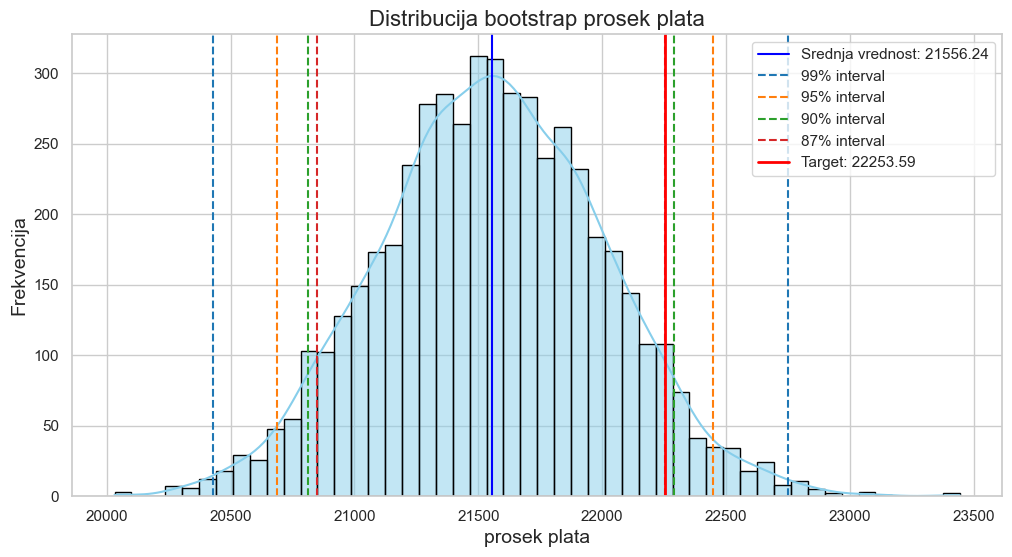

In [430]:
bole.plot()

Na slici je prikazana distribucija sredina dobijenih bootstrap uzorkovanjem. Prosečna zarada iz konkretnog uzorka (označena crvenom linijom) se nalazi unutar 87% intervala poverenja, što implicira da bi uzorak sa sličnijom sredinom nego ovaj uzorak bio dobijen u oko 87.8% slučajeva prilikom slučajnog uzorkovanja iz populacije.

Drugim rečima, verovatnoća da se iz populacije izvuče uzorak čija prosečna plata odstupa apsolutno manje od sredine baze (simulirano sa k uzoraka), što govori u prilog tome da je uzorak reprezentativan i ne odstupa značajno od očekivanja.

In [432]:
bole.describe()

--- OPIS PODATAKA ---

Uzorak:


,starost,satiRada,plata,obrazovanje
count,"325,00","325,00","325,00","325,00"
mean,"40,58","43,51","22.253,59","12,24"
std,"10,87","6,52","8.948,16","2,10"
min,"18,00","30,00","9.600,00","8,00"
25%,"32,00","40,00","15.000,00","11,00"
50%,"41,00","40,00","20.000,00","12,00"
75%,"49,00","48,00","28.000,00","12,00"
max,"63,00","60,00","60.000,00","18,00"



Populacija:


,starost,satiRada,plata,obrazovanje
count,"3.195,00","3.195,00","3.195,00","3.195,00"
mean,"40,58","43,42","21.569,35","11,81"
std,"10,35","6,68","8.720,20","2,39"
min,"16,00","28,00","8.000,00","0,00"
25%,"32,00","40,00","15.000,00","11,00"
50%,"41,00","40,00","20.000,00","12,00"
75%,"49,00","48,00","26.000,00","12,00"
max,"64,00","60,00","64.000,00","20,00"



--- TOTALI OBELEŽJA ---



,Total mesečne zarade,Total godina obrazovanja
Populacija,"68.914.076,00","37.735,00"
Uzorak (korigovan),"71.100.212,68","39.116,63"


Slučajnim odabirom 325 ispitanika odabrani ljudi u proseku malo više rade, više su plaćeni i obrazovaniji su u odnosu na celu bazu.

In [438]:
bole.kolicnickoOcenjivanje()


--- KOLIČNIČKO OCENJIVANJE ---



,Vrednost
Količnik populacije (R),"1.826,26"
Količnik uzorka (Ru),"1.817,65"
Sredina Y količnički,"21.467,57"
Stvarna sredina Y,"21.569,35"
Pristrasnost sredine,"-101,78"
Relativna pristrasnost (%),-0.47%
Total Y količnički,"68.588.896,14"
Stvarni total Y,"68.914.076,00"
Pristrasnost totala,"-325.179,86"



--- STANDARDNE DEVIJACIJE ---


,Standardna devijacija
Totala Y,"1.340.758,50"
Sredine Y,"419,64"
Količnika,"35,53"



--- INTERVALI POVERENJA ---


,Ocena,Standardna devijacija,Donja granica,Gornja granica,Raspon,Sadrži pravu vrednost
Interval,,,,,,
99.0%,"21.467,57","419,64","20.380,24","22.554,90","2.174,66",DA
95.0%,"21.467,57","419,64","20.642,00","22.293,14","1.651,14",DA
90.0%,"21.467,57","419,64","20.775,34","22.159,80","1.384,46",DA
87.9%,"21.467,57","419,64","20.815,38","22.119,77","1.304,39",DA


Količničko ocenjivanje se vrši na osnovu varijable obrazovanje.

Kada se kontroliše za prosešnu razliku u obrazovanju uzorka u odnosu na bazu, dobija se ocena koja je pristrasna naniže za 100 (običan prosek je pristrasan oko 700 naviše) sa standardnom devijacijom ocene sredine 420.

Količnička ocena ukupne plate podcenjuje za 325 hiljada dinara.

Svi intervali poverenja sadrže sredinu baze

In [441]:
bole.regresionoOcenjivanje()


--- REGRESIONO OCENJIVANJE ---

Metodom običnih najmanjih kvadrata ocenjen je model:


,koeficijent,std,t,sig
const,"-16.202,13","4.702,88","-3,45",***
starost,"126,78","40,11","3,16",***
satiRada,"261,32","67,48","3,87",***
obrazovanje,"1.935,26","219,54","8,81",***
region_Juzna i Jugoistocna Srbija,"-2.177,61","1.279,57","-1,70",*
region_Sumadija i Zapadna Srbija,"-894,55","1.170,66","-0,76",
region_Vojvodina,"-2.832,93","1.258,80","-2,25",**
urban_Selo,"549,39","968,80","0,57",
zene_Zena,"-1.257,20","884,46","-1,42",



Značajni parametri nakon iterativne eliminacije:
Promenjiva urban_Selo je statisticki neznacajna, t vrednost:
0.5670815941763382
Promenjiva zene_Zena je statisticki neznacajna, t vrednost:
-1.452238642424686


,koeficijent,std,t,sig
const,"-17.081,31","4.490,00","-3,80",***
starost,"130,24","39,93","3,26",***
satiRada,"281,42","66,15","4,25",***
obrazovanje,"1.882,73","207,25","9,08",***
region_Juzna i Jugoistocna Srbija,"-1.912,45","1.267,47","-1,51",
region_Sumadija i Zapadna Srbija,"-707,22","1.165,23","-0,61",
region_Vojvodina,"-2.746,51","1.256,28","-2,19",**



Jednačina modela:
plata = -17.081,31 + 130,24 *starost + 281,42 *satiRada + 1.882,73 *obrazovanje + -1.912,45 *region_Juzna i Jugoistocna Srbija + -707,22 *region_Sumadija i Zapadna Srbija + -2.746,51 *region_Vojvodina

--- OCENE SREDINE ---


,Vrednost
Regresiona ocena sredine (poznat Xm),"21.314,31"
Standardna devijacija regresione ocene,"460,35"
Pristrasnost regresione ocene,"-255,04"
Regresiona ocena sredine (uzorak),"22.253,59"



--- INTERVALI POVERENJA ---


,Ocena,Standardna devijacija,Donja granica,Gornja granica,Raspon,Sadrži pravu vrednost
Interval,,,,,,
99.0%,"21.314,31","460,35","20.121,49","22.507,13","2.385,64",DA
95.0%,"21.314,31","460,35","20.408,65","22.219,97","1.811,32",DA
90.0%,"21.314,31","460,35","20.554,93","22.073,70","1.518,77",DA
87.9%,"21.314,31","460,35","20.598,84","22.029,78","1.430,94",DA



--- OCENE TOTALA ---


,Vrednost
Regresiona ocena totala (populacija),"68.099.226,96"
Regresiona ocena totala (proširen uzorak),"71.100.212,68"
Stvarni total,"68.914.076,00"



--- SREDNJE KVADRATNE GREŠKE ---


,Vrednost
SKG količničkog ocenjivanja,"186.458,72"
SKG regresionog ocenjivanja,"276.970,79"


Kada se metodom Običnih Najmanjih Kvadrata oceni zarada u uzorku varijable koje označavaju pol i vrstu naselja su neznačajne, one se izbacuju iz modela. 

Ocenjen model onda izgleda ovako:

plata = -17.081,31 + 130,24 *starost + 281,42 *satiRada + 1.882,73 *obrazovanje + -1.912,45 *region_Juzna i Jugoistocna Srbija + -707,22 *region_Sumadija i Zapadna Srbija + -2.746,51 *region_Vojvodina

Ako je prosek godina obrazovanja poznat u populaciji ocena prosečne zarade je pristrasna naniže oko 250, a ako nije onda je ocena pristasna oko 700 na više.

Svi intervali sadrže sredinu baze.

Kako je srednja kvadratna greška količničkog ocenjivanja niža od SKG regresionog ocenjivanja zaključujem da je količničko ocenjivanje preciznije za PSU ovog obima



In [446]:
class SSU(PSU):
    """
    Stratifikovani Slučajni Uzorak (SSU) - podklasa PSU za rad sa stratifikacijom
    """

    def __init__(self, df, X, Y, n, stratumi, alfa=[0.1, 0.05, 0.01], seed=1304):
        super().__init__(df, X, Y, n, alfa=alfa, seed=seed)

        self.df['Strata'] = self.df[stratumi].astype(str).agg('_'.join, axis=1)
        self.stratumi = stratumi
        self.strataCounts = self.df['Strata'].value_counts(normalize=True)
        self.nh = (self.strataCounts * n).round().astype(int)
    
        self.uzorak = pd.concat([self.df[self.df['Strata'] == strata].sample(n=size, random_state=seed) 
                                 for strata, size in self.nh.items()])
        self.x = self.uzorak['obrazovanje']
        self.y = self.uzorak['plata']
        self.X = self.df['obrazovanje']
        self.Xtotal = self.X.sum()
        self.Y = self.df['plata']
        self.Ym = self.Y.mean()
        self.Ytotal = self.Y.sum() 
        self.N = self.df.shape[0]
        self.n = self.uzorak.shape[0]
        self.f = self.n / self.N
        self.nh = self.uzorak['Strata'].value_counts()
        self.Nh = self.df['Strata'].value_counts()
        self.ybarh = self.uzorak.groupby('Strata')['plata'].mean()
        self.Wh = self.Nh / self.N
        self.fh = self.nh / self.Nh
        self.S2h = self.uzorak.groupby('Strata')['plata'].var()
    def describe(self):
        print("--- Uzorak: ---")
        display(pd.DataFrame(self.nh))
        display(self.uzorak.describe())
        print("--- Populacija: ---")
        display(self.df.describe())
        ybarSt = self.Nh @ self.ybarh / self.N
        
        VybarSt = ((1 - self.f) / self.N) * self.Wh @ (self.S2h)
        SybarSt = np.sqrt(VybarSt)
        intervali = []
        self.intervaliPoverenja(ybarSt, SybarSt)

        YtotalSt = self.N * ybarSt
        SYtotalSt = self.N * SybarSt

        self.intervaliPoverenja(YtotalSt, SYtotalSt, parametar= self.Y.sum())
        
    def kolicnickoOcenjivanje(self):
        Yh = self.df.groupby('Strata')['plata'].sum()
        Xh = self.df.groupby('Strata')['obrazovanje'].sum()
        Rh = Yh / Xh
        rho = self.uzorak.groupby('Strata')['obrazovanje'].corr(self.y)
        yh = self.uzorak.groupby('Strata')['plata'].sum()
        xh = self.uzorak.groupby('Strata')['obrazovanje'].sum()
        Sx2h = self.uzorak.groupby('Strata')['obrazovanje'].var()
        YtotalRs = (yh / xh) @ (Xh)
        SYtotalRs = np.sqrt((((np.square(self.Nh) * (1 - self.f))) / self.nh) @ 
                            ((self.S2h + np.square(Rh) * Sx2h - (2 * Rh * rho.values * np.sqrt(self.S2h) * np.sqrt(Sx2h)))))
        print('\n--- KOLIČNIČKO OCENJIVANJE ---\n')

        print('korelacija godina obrazovanja sa zaradom po stratumima'.upper(), display(pd.DataFrame(rho)), sep='\n')

        self.intervaliPoverenja(YtotalRs, SYtotalRs, parametar= self.Y.sum())
        
        

        
# 
# Ytotal90Rs = (round(YtotalRs - t * SYtotalRs), round(YtotalRs + t * SYtotalRs))
# SYbarRs = SYtotalRs / N
# YbarRs = YtotalRs / N
# Ybar95Rs = (round(YbarRs - t * SYbarRs), round(YbarRs + t * SYtotalRs))

# print('Posebna količnička ocena prosecne mesecne zarade je:\n', form(YbarRs), '\nPristrasnost', form(YbarRs - Ym))
# print('Standardna devijacija posebne količničke ocene sredine stratifikovanim slucajnim uzorkom je', form(SYbarRs))
# print('95% interval ocene totala posebnom kolicnickom ocenom je', Ybar95Rs)
# print(f'Posebna kolicnicka ocena totala populacije {form(YtotalRs)}', f'Pristrasnost {form(YtotalRs - Ytotal)}', sep='\n')
# print(f'Standardna devijacija ocene totala stratifikovanim slucajnim uzorkom je {form(SYtotalRs)}')
# print('\nKombinovana kolicnicka ocena'.upper())

# xbarh = uzorak.groupby('Strata')['obrazovanje'].mean()
# xbarSt = Nh.dot(xbarh) / N
# YtotalRc = ybarSt / xbarSt * Xtotal
# YbarRc = YtotalRc / N

# print(f'Kombinovana kolicnicka ocena sredine populacije je {form(YbarRc)}', f'Pristrasnost {form(YbarRc - Ym)}', sep='\n')
# print(f'Kombinovana kolicnicka ocena totala populacije je {form(YtotalRc)}', f'Pristrasnost {form(YtotalRc - Ytotal)}', sep='\n')


In [474]:

skola = pd.read_csv(r"https://raw.githubusercontent.com/BogdanSliskovic/Ocenjivanje-prosecne-i-ukupne-plate-u-Srbiji-2007/refs/heads/main/podaci/stanovnistvoPoObrazovanju2011.csv")
education_mapping = {
    'Bez školske spreme': 'Osnovno skola ili manje',
    'Nepotpuno osnovno obrazovanje': 'Osnovno skola ili manje',
    'Osnovno obrazovanje': 'Osnovno skola ili manje',
    'Srednje obrazovanje - svega': 'Srednja skola',
    'Više obrazovanje': 'Visoko obrazovanje',
    'Visoko obrazovanje': 'Visoko obrazovanje'
}
skola
skola['obrPop'] = skola['Školska sprema'].map(education_mapping)
skola
skola.index = skola['Školska sprema']
skola.pop('Školska sprema')
skola = skola.groupby('obrPop').sum()
skola = skola.iloc[:,0]
print(skola)
N = skola.sum()
Nh = (skola / N).sort_index()
df['strataObr'] = df['obr3'].astype(str)
nh = df.value_counts('strataObr', normalize= True).sort_index()
print(Nh,nh)
ponderObr = Nh / nh
print(ponderObr)
df['ponderObr'] = df['obr3'].map(ponderObr)
print(df['ponderObr'])
df['ponderObr'] = df['ponderObr'].astype(float)
ybarh = df.groupby('strataObr')['plata'].mean()
print(ybarh)
ybarSrb = Nh.dot(ybarh)
ytotalSrb = (ybarSrb * N)
ytotalSrbGodisnje = ytotalSrb * 12 / 10**6
pd.options.display.float_format = "{:.2f}".format
print('Prosecna plata u Srbiji:',ybarSrb)
print('Ocena totala mesecnih zarada u Srbiji je:',ytotalSrb.round(), 'Ocena ukupne godisnje zarade u Srbiji je:', ytotalSrbGodisnje.round(), 'miliona dinara')
porezi = pd.read_csv(r'read_csv(r"https://raw.githubusercontent.com/BogdanSliskovic/Ocenjivanje-prosecne-i-ukupne-plate-u-Srbiji-2007/refs/heads/main/podaci/poreziSubv2007.csv',index_col=0).iloc[0]
netoPorez = porezi.iloc[0] - porezi.iloc[1]
brutoPoslovniVisak = pd.read_csv(r"https://raw.githubusercontent.com/BogdanSliskovic/Ocenjivanje-prosecne-i-ukupne-plate-u-Srbiji-2007/refs/heads/main/podaci/brutoPoslovniVisak.csv",index_col=0).iloc[0].iloc[0]
BDP = ytotalSrbGodisnje + netoPorez + brutoPoslovniVisak
print(f'Ocena BDPa je: {round(BDP,2)} miliona dinara')
print('Stvarni BDP je bio 2623862.4 miliona dinara')

obrPop
Osnovno skola ili manje    2121499
Srednja skola              3015092
Visoko obrazovanje         1000569
Name: Unnamed: 1, dtype: int64


KeyError: 'obr3'

In [478]:
pd.read_csv(r"https://raw.githubusercontent.com/BogdanSliskovic/Ocenjivanje-prosecne-i-ukupne-plate-u-Srbiji-2007/refs/heads/main/podaci/stanovnistvoPoObrazovanju2011.csv")

,Školska sprema,Unnamed: 1
0,Bez školske spreme,164884
1,Nepotpuno osnovno obrazovanje,677499
2,Osnovno obrazovanje,1279116
3,Srednje obrazovanje - svega,3015092
4,Više obrazovanje,348335
5,Visoko obrazovanje,652234


In [480]:
regPol = pd.read_csv(r'read_csv(r"https://raw.githubusercontent.com/BogdanSliskovic/Ocenjivanje-prosecne-i-ukupne-plate-u-Srbiji-2007/refs/heads/main/podaci/regionPol2007.csv',index_col=0)
regPol.index = regPol.index.to_series().ffill()
regPol = regPol.drop('Starosne grupe', axis = 1)
regPol = regPol.groupby(regPol.index).sum()
df['strataRegPol'] = df['region'].astype(str)+ df['zene'].astype(str)
Nh = (regPol / regPol.sum().sum()).sort_index()
nh = df.value_counts('strataRegPol', normalize=True).sort_index()
print(Nh,f'\n{nh}')
Nh = Nh.stack().reset_index(name='ponderRegPol')
Nh.index = Nh.iloc[:,0] + Nh.iloc[:,1]
Nh = Nh['ponderRegPol']

ponderRegPol = Nh / nh
df['ponderRegPol'] = df['strataRegPol'].map(ponderRegPol)
df.ponderRegPol = df.ponderRegPol.astype(float) 
ybarh = df.groupby('strataRegPol')['plata'].mean()
print(ybarh)
ybarSt = ybarh.dot(Nh)
ytotalSrbGodisnje = (ybarSt * N) * 12 / 10**6
print('Prosecna plata u Srbiji:',round(ybarSt,2), sep = '\n')
porezi = pd.read_csv(r'read_csv(r"https://raw.githubusercontent.com/BogdanSliskovic/Ocenjivanje-prosecne-i-ukupne-plate-u-Srbiji-2007/refs/heads/main/podaci/poreziSubv2007.csv',index_col=0).iloc[0]
netoPorez = porezi.iloc[0] - porezi.iloc[1]
brutoPoslovniVisak = pd.read_csv(r'read_csv(r"https://raw.githubusercontent.com/BogdanSliskovic/Ocenjivanje-prosecne-i-ukupne-plate-u-Srbiji-2007/refs/heads/main/podaci/brutoPoslovniVisak.csv',index_col=0).iloc[0].iloc[0]
BDP = ytotalSrbGodisnje + netoPorez + brutoPoslovniVisak
print(f'Ocena BDPa je: {round(BDP,2)} miliona dinara')
print('Stvarni BDP je bio 2623862.4 miliona dinara')

OSError: [Errno 22] Invalid argument: 'read_csv(r"https://raw.githubusercontent.com/BogdanSliskovic/Ocenjivanje-prosecne-i-ukupne-plate-u-Srbiji-2007/refs/heads/main/podaci/regionPol2007.csv'